<a href="https://colab.research.google.com/github/shreyashrivastava1/BrainTumorClassification/blob/main/CNN_RESNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import itertools
!pip install opendatasets
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout,BatchNormalization

import warnings
warnings.filterwarnings('ignore')


In [ ]:
import opendatasets as od
od.download(
    "https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c/data")


ModuleNotFoundError: No module named 'opendatasets'

In [ ]:
data_dir = '/content/brain-tumor-mri-images-44c'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    print(fold)
    foldpath = os.path.join(data_dir, fold)
    print(foldpath)
    filelist = os.listdir(foldpath)
    print(filelist)

    for file in filelist:
        fpath = os.path.join(foldpath, file)
        # print(fpath)
        filepaths.append(fpath)
        labels.append(fold)


FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='labels')

df = pd.concat([FSeries, LSeries], axis=1)
display(df)

Oligodendroglioma T2
/content/brain-tumor-mri-images-44c/Oligodendroglioma T2
['Anonymize.Seq9.Ser9.Img17_big_gallery.jpeg', '8d4bd159475d2a7f0a75cfcdf11105_big_gallery.jpeg', '445572b309c1d005a0b8831f1bab51_big_gallery.jpeg', '68c330a9b8fd2abec44c72ec507140_big_gallery.jpeg', '0a8725a3268ebc49e12b98204fe21d_big_gallery.jpeg', '6d2656f8bcd5132d56c6f29ed0cf90_big_gallery.jpeg', '197227d23e999bd74c3346096f688d_big_gallery.jpeg', '64f1ac4559d73b0d978dbf261e4069_big_gallery.jpeg', 'd94ce21f62eed49a76831d4fa7a86c_big_gallery.jpeg', 'f481bbd18a960a4edeacecc0de07d6_big_gallery.jpeg', '1eca2f2a74c931e67be8909d62513c_big_gallery.jpeg', 'ffa2e58272ac6934a6147b05776ea0_big_gallery.jpeg', '34b8af2d0a07221605affbd0efaa82_big_gallery.jpeg', '9f74928bc54049d3cab61c7294f2db_big_gallery.jpeg', '35e5eea2a8c3495af9b3573d364a07_big_gallery.jpeg', 'a09c01034ae004696aec874d5ab534_big_gallery.jpeg', 'ef5c744704eab493f595fa101578b8_big_gallery.jpeg', '8374e2ae958a556fe10caf7b7e8928_big_gallery.jpeg', '583b757

,filepaths,labels
0,/content/brain-tumor-mri-images-44c/Oligodendr...,Oligodendroglioma T2
1,/content/brain-tumor-mri-images-44c/Oligodendr...,Oligodendroglioma T2
2,/content/brain-tumor-mri-images-44c/Oligodendr...,Oligodendroglioma T2
3,/content/brain-tumor-mri-images-44c/Oligodendr...,Oligodendroglioma T2
4,/content/brain-tumor-mri-images-44c/Oligodendr...,Oligodendroglioma T2
...,...,...
4474,/content/brain-tumor-mri-images-44c/Neurocitom...,Neurocitoma T1
4475,/content/brain-tumor-mri-images-44c/Neurocitom...,Neurocitoma T1
4476,/content/brain-tumor-mri-images-44c/Neurocitom...,Neurocitoma T1
4477,/content/brain-tumor-mri-images-44c/Neurocitom...,Neurocitoma T1


In [ ]:
df['labels'].value_counts()

labels
Meningioma T1C+           369
Meningioma T1             272
_NORMAL T2                271
_NORMAL T1                251
Meningioma T2             233
Astrocitoma T1C+          233
Neurocitoma T1C+          223
Schwannoma T1C+           194
Astrocitoma T1            176
Astrocitoma T2            171
Schwannoma T1             148
Neurocitoma T1            130
Schwannoma T2             123
Carcinoma T1C+            112
Papiloma T1C+             108
Neurocitoma T2            104
Glioblastoma T1C+          94
Oligodendroglioma T1       86
Tuberculoma T1C+           84
Carcinoma T2               73
Oligodendroglioma T1C+     72
Meduloblastoma T1C+        67
Oligodendroglioma T2       66
Carcinoma T1               66
Papiloma T1                66
Papiloma T2                63
Ependimoma T2              57
Glioblastoma T2            55
Glioblastoma T1            55
Ependimoma T1C+            48
Ependimoma T1              45
Meduloblastoma T2          41
Germinoma T1C+             40
Ger

In [ ]:
train_df, dummy_df = train_test_split(df, train_size=0.8, random_state=42, stratify=df['labels'])

valid_df, test_df = train_test_split(dummy_df, train_size=0.5, random_state=42, stratify=dummy_df['labels'])

In [ ]:
batch_size = 32
image_size = (224, 224)

gen = ImageDataGenerator()

train_gen = gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', class_mode='categorical',
                                   color_mode = 'rgb', target_size=image_size, batch_size=batch_size)

valid_gen = gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', class_mode='categorical',
                                   color_mode = 'rgb', target_size=image_size, batch_size=batch_size)

test_gen = gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', class_mode='categorical',
                                   color_mode = 'rgb', target_size=image_size, batch_size=batch_size)


Found 3583 validated image filenames belonging to 44 classes.
Found 448 validated image filenames belonging to 44 classes.
Found 447 validated image filenames belonging to 44 classes.


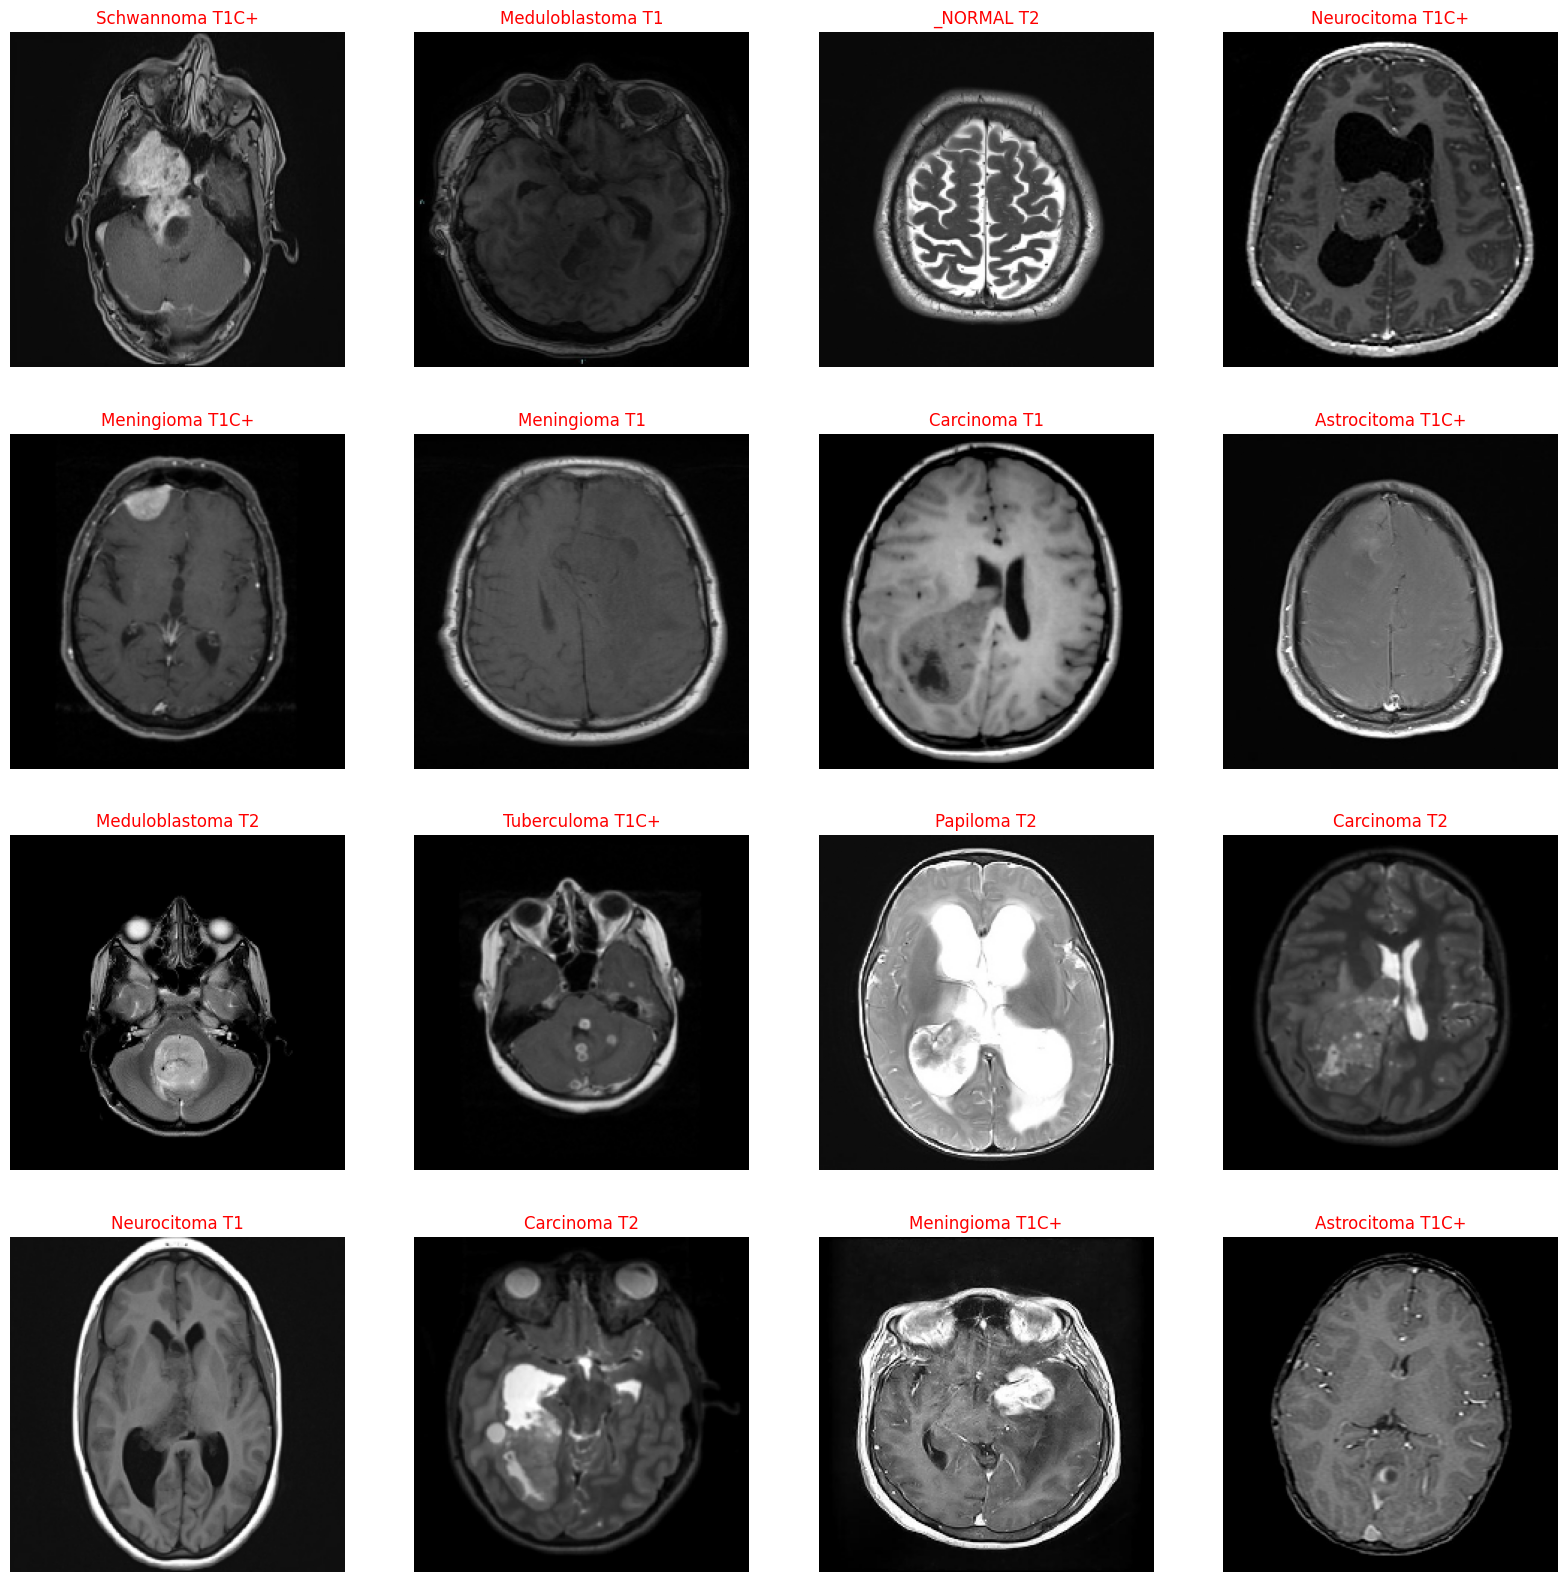

In [ ]:
g_dict = train_gen.class_indices
classes= list(g_dict.keys())

images, labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range (16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index= np.argmax(labels[i]) #[0,0,0,1,0]
    class_name = classes[index]
    plt.title(class_name,c='r', fontsize=12)
    plt.axis('off')
plt.show()

In [ ]:
def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1

In [ ]:
image_size = (224, 224)
channels = 3
image_shape = (image_size[0], image_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))
base_model = tf.keras.applications.ResNet50(include_top=False,                   # fully connected layers (top) of the model, responsible for classification, are not included.
                                                     weights='imagenet',
                                                     input_shape = image_shape,
                                                     pooling= 'max')

model = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),         #helps in stabilizing and accelerating the learning process, axis=-1 => normalisation on the feature axis;It means that for each feature, the mean and standard deviation will be computed independently.
                                                                          #momentum: 99% of the previous statistics will be retained. Usually done for stablisation
                                                                          #epsilon: avoid division by zero in the normalisation process[esp if the variance is very small]
    Dense(256,kernel_regularizer= regularizers.l2(l= 0.016),bias_regularizer= regularizers.l1(0.006),activity_regularizer= regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),])

model.summary()




#activity_regularizer= regularizers.l1(0.006), bias_regularizer= regularizers.l1(0.006)

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 44)                11

In [ ]:
hist= model.fit(train_gen, epochs= 10, verbose= 1, validation_data= valid_gen, shuffle= False )

Epoch 1/10
112/112 [==============================] - 92s 402ms/step - loss: 9.3277 - accuracy: 0.5096 - precision: 0.7753 - recall: 0.3852 - val_loss: 9.3755 - val_accuracy: 0.4754 - val_precision: 0.5942 - val_recall: 0.4085
Epoch 2/10
112/112 [==============================] - 40s 359ms/step - loss: 6.5824 - accuracy: 0.8147 - precision: 0.9316 - recall: 0.6916 - val_loss: 5.9530 - val_accuracy: 0.8125 - val_precision: 0.9238 - val_recall: 0.7031
Epoch 3/10
112/112 [==============================] - 40s 357ms/step - loss: 4.9280 - accuracy: 0.9528 - precision: 0.9860 - recall: 0.8677 - val_loss: 4.5344 - val_accuracy: 0.9040 - val_precision: 0.9778 - val_recall: 0.7857
Epoch 4/10
112/112 [==============================] - 40s 356ms/step - loss: 3.7523 - accuracy: 0.9874 - precision: 0.9965 - recall: 0.9450 - val_loss: 3.4516 - val_accuracy: 0.9375 - val_precision: 0.9793 - val_recall: 0.8460
Epoch 5/10
112/112 [==============================] - 40s 356ms/step - loss: 2.8676 - accura

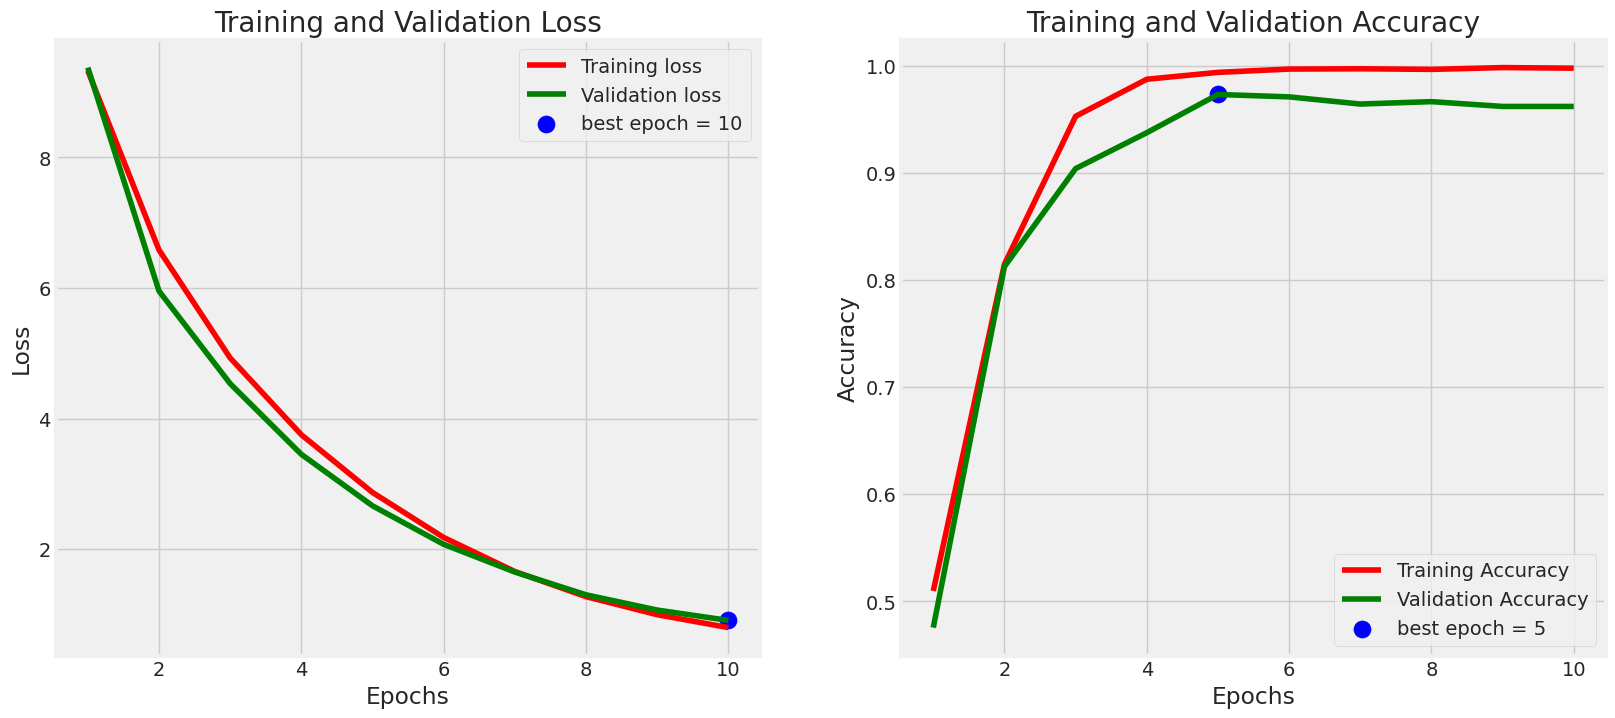

In [ ]:

tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch = {str(index_loss + 1)}'
acc_label = f'best epoch = {str(index_acc + 1)}'

# Plot training history

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label = 'Training loss')
plt.plot(Epochs, val_loss, 'g', label = 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score= model.evaluate(train_gen)
valid_score= model.evaluate(valid_gen)
test_score=  model.evaluate(test_gen)


14/14 [==============================] - 2s 113ms/step - loss: 0.9718 - accuracy: 0.9463 - precision: 0.9822 - recall: 0.8658


In [ ]:


print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('=' * 20)
print( )
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('=' * 20)
print( )
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])



Train Loss:  0.674071192741394
Train Accuracy:  0.9983254075050354

Valid Loss:  0.9072845578193665
Valid Accuracy:  0.9620535969734192

Test Loss:  0.9717942476272583
Test Accuracy:  0.9463087320327759
